# Advanced Models Data Analysis

#  Project 2

# Used Vehicle Price Prediction

## Members:

* Catalina Lago Martinez - 201113637

* Camilo Andrés Angarita Ortiz - 201111642

* Sergio Ardila Rodríguez - 201924139 

## 1. Objectives

* Build efficient car price prediction model based on Machine Learning.
* Select the best prediction Model based on their Performance.
* Expose the model as an API on a cloud service.

## 2. Methodology

In order to select an effective car price prediction model, the Analytics team selected a DataBase from TrueCar.com that contains car data by the following aggregation:

* Year.
* Mileage
* State.
* Make.
* Model.

Three models based on Regression Trees will be used for evaluation:
* Bagged Trees.
* Random Forest.
* XG Boosting.

The current prediction seeks to find the most accurate price for a car considering its principal features, in which the performance indicator to select the model will be the RMSE (Square Root of Mean Square Error).

### 2.1. Data Preliminar Analysis

- 1.2 Million listings scraped from TrueCar.com - Price, Mileage, Make, Model dataset from Kaggle: [data](https://www.kaggle.com/jpayne/852k-used-car-listings)
- Each observation represents the price of an used car

In [2]:
#Library Import 

%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
import category_encoders as ce
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error
from statistics import mean 
from random import randrange

In [3]:
data = pd.read_csv('../datasets/dataTrain_carListings.zip')

In [4]:
data.head()

,Price,Year,Mileage,State,Make,Model
0,21490,2014,31909,MD,Nissan,MuranoAWD
1,21250,2016,25741,KY,Chevrolet,CamaroCoupe
2,20925,2016,24633,SC,Hyundai,Santa
3,14500,2012,84026,OK,Jeep,Grand
4,32488,2013,22816,TN,Jeep,Wrangler


In [5]:
data.shape

(500000, 6)

In [6]:
data.dtypes

Price       int64
Year        int64
Mileage     int64
State      object
Make       object
Model      object
dtype: object

In [7]:
data.Price.describe()

count    500000.000000
mean      21144.186304
std       10753.259704
min        5001.000000
25%       13499.000000
50%       18450.000000
75%       26998.000000
max       79999.000000
Name: Price, dtype: float64

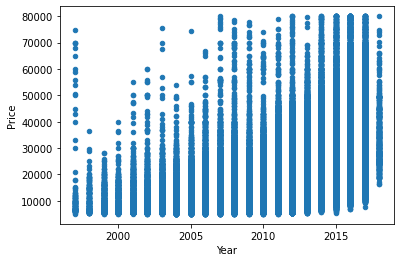

In [8]:
data.plot(kind='scatter', y='Price', x='Year')

There is a correlation between the Mileage and Car Price. The year affect the price of the car, If the year of the car is recent, the more the Car Price will be.

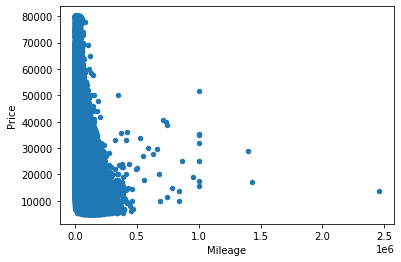

In [9]:
data.plot(kind='scatter', y='Price', x='Mileage')

There is a correlation between the Mileage and Car Price. In this case the less Mileage, the less the Car Price will be.

In [10]:
data.columns

Index(['Price', 'Year', 'Mileage', 'State', 'Make', 'Model'], dtype='object')

A random sample (50000 Observations)  is taken from computational purposes.

In [11]:
data=data.sample(n=50000, random_state=1) # Se toma una muestra aleatoria de la base para hacer los entrenamientos y calibración de parametros

### 2.2. Data Processing

Car Listings brings information of the price of a car due to its key information.

The type of every parameter is considered as it follows:
* Year: Numeric.
* Mileage: Numeric.
* State: Categorical.
* Make: Categorical.
* Model: Categorical.

In [11]:
# Predictor Set
X_cat = data[["State", "Make", "Model"]]
X_num = data[["Year","Mileage"]]

In [12]:
encoder = ce.BinaryEncoder().fit(X_cat,axis=1)
X_cat = encoder.transform(X_cat)

In [13]:
X = pd.concat([X_num,X_cat],  axis=1, sort = False)

In [14]:
# Showing Predictor Data Frame Header

X.head()

,Year,Mileage,State_0,State_1,State_2,State_3,State_4,State_5,State_6,Make_0,...,Model_0,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9
352806,2008,46967,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
417824,2017,36633,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
469847,2013,41615,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,1
407746,2016,33050,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
469848,2014,94639,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,1


The Predictor Dataset will be hace 1000 observations and 594 variables

In [16]:
# Dependent Variable
y = data['Price']

# 3. Model Selection

The Machine Learning Models that will be evaluated are:

* Bagged Trees.
* Random Forest.
* XGBoosting.

In order to test the effectiveness of the models, they will be evaluated using a cross validation algorithm.

## 3.1. Cross Validation Algorithm

Cross validation is one of the techniques used to test the effectiveness of machine learning models, it is also a re-sampling procedure used to evaluate a model if we have limited data.

Since we have a large amount of data (500k rowsx546 colums), cross validation could be a good tool to reduce the computational load on the machine and get the best results with a limited sample of data.

We have created our own Cross Validation Algorithm. As it follows:

In [17]:
# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3, random_state=1)

In [18]:
# function that creates the k folds splits 

from random import randrange

def cross_validation_split(dataset, folds):
        dataset_split = []
        dataset_split_index = []
        df_copy = dataset
        fold_size = int(df_copy.shape[0] / folds)
        
        # for loop to save each fold
        for i in range(folds):
            fold = []
            fold_index=[]
            # while loop to add elements to the folds
            while len(fold_index) < fold_size:
                # select a random element
                r = randrange(df_copy.shape[0])
                # determine the index of this element 
                index = df_copy.index[r]
                # save the randomly selected line 
                #fold.append(df_copy.loc[index].values.tolist())
                fold_index.append(df_copy.index[r].tolist())
                # delete the randomly selected line from
                # dataframe not to select again
                df_copy = df_copy.drop(index)
            # save the fold     
            #dataset_split.append(np.asarray(fold)) 
            dataset_split_index.append(np.asarray(fold_index))
            
        return dataset_split_index 

In [19]:
# function that defines the test and train sets for each iteration

def k_cv(dataset, f):
    data=cross_validation_split(dataset,f)
    test_index=[]
    train_index=[]
    
    #se defininen los tamaños de los sets 
    #para el set de training el tamaño es igual (k-1)*x[0].shape[0]
    #para el test set el tamaño es igual a x[0].shape[0]
    # determine training and test sets 
    
    for i in range(f):
        lista=data.copy()
        test_index.append(np.asarray(data[i]))
        lista.pop(i)
        x=np.concatenate(lista, axis=None )
        train_index.append(np.asarray(x))
       
    return [train_index, test_index]

In [20]:
# Kfold cross validation function definition

def cross_validation(X_train, y_train, model,k=10):
    
    scores = []
    
    cv = k_cv(X_train,k)

    train=cv[0]
    test=cv[1]
    
    
    for train_index in range(k): 
        
        for test_index in range(k):
            
                X_train_rf, X_test_rf, y_train_rf, y_test_rf =X_train.loc[train[train_index]], X_train.loc[test[test_index]], y_train.loc[train[train_index]], y_train.loc[test[test_index]]
    
    model.fit(X_train_rf, y_train_rf)
    y_pr=model.predict(X_test_rf)
    scores.append(mean_squared_error(y_test_rf, y_pr)**0.5)
    
    return mean(scores)

## 3.2. Bagged Trees

Decision trees are sensitive to the specific data on which they are trained. Bootstrap Aggregation is a general procedure that can be used to reduce the variance for those algorithm that have high variance.

A Bagging Classifier meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (in this case, will be used for a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

An algorithm that has high variance are decision trees, like classification and regression trees (CART). For this prediction, we will use Regression trees.


In [21]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [22]:
# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3, random_state=1)

In [23]:
# Instruct BaggingRegressor to use DecisionTreeRegressor as the "base estimator"
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, 
                          bootstrap=True, oob_score=True, random_state=42)

In [24]:
# fit and predict
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)

In [25]:
np.sqrt(mean_squared_error(y_test, y_pred))

5462.543887199206

For Bagged Trees we obtained $5.462 of Mean Square Error.


#### Parameter Tuning

In order to obtain a more accurate prediction for car price through Bagged Trees, we calibrate every parameter to evaluate the Resulting MSE.

One of the principal parameters in Bagged Trees is n_estimators, which represents the base number of trees in the ensemble. This value will be evaluated between 10 to 1000 jumping from 100 to 100.

In [26]:
#Calibrating the parameter n_stimators

# finding best value for learning_rate
n_estimators_range = range(10, 250, 50)

# list to store the average RMSE
accuracy_scores = []

for n in n_estimators_range:
    bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=n, 
                          bootstrap=True, oob_score=True, random_state=42)
    bagreg.fit(X_train, y_train)
    y_pred = bagreg.predict(X_test)
    accuracy_scores.append(mean_squared_error(y_test, y_pred)**0.5)

C:\Users\kata_\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:1066: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Text(0, 0.5, 'MSE')

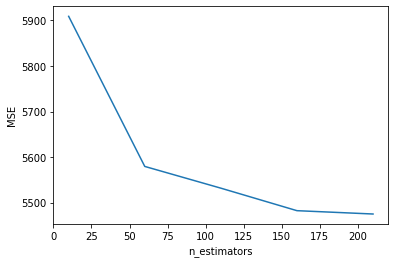

In [27]:
plt.plot(n_estimators_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('MSE')

In [28]:
results = {'values':n_estimators_range, 'MSE': accuracy_scores}
res2 = pd.DataFrame(data=results)
res2

,values,MSE
0,10,5909.066945
1,60,5579.661273
2,110,5531.964449
3,160,5482.555746
4,210,5475.230700


After the n_estimators tunning, we found that the MSE can be reduced Bagging the trees with 210 estimators, for which the MSE resultant will be $5.475 for a car price prediction.

In order to obtain a more accurate prediction, we search if there is a better machine learning algorithm.

## 3.3. Random Forest

It is a bagging-based algorithm with a key difference wherein only a subset of features is selected at random.A random forest regressor is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

In [61]:
# Random forest 
clf = RandomForestRegressor(random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
y_pr=clf.predict(X_test)
mean_squared_error(y_test, y_pr)**0.5

5431.569822248924

Applying Random Forest we obtained $5.501 of Mean Square Error predincting the price of a car given some requested features.

#### Parameter tunning

In order to obtain a better MSE in our Random Forest Prediction, we calibrate our parameters and observe the results. 

 

In this case we will change:

 

n_estimators: represents the number of trees in the forest. Usually the higher the number of trees the better to learn the data. 
However, adding a lot of trees can slow down the training process considerably,therefore we do a parameter search to find the sweet spot.

 

This Tuning is done in order to reduce overfitting.

In [62]:
# findind the best n_estimators: 

# list of values to try for n_estimators
estimator_range = range(10, 1000, 100)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_validation(X_train, y_train, clf,k=10))
    

Text(0, 0.5, 'MSE')

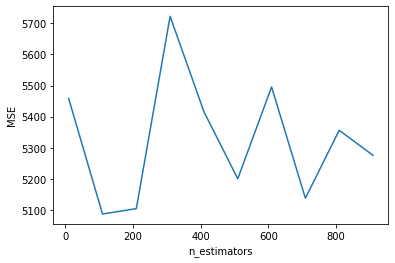

In [63]:
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('MSE')

In [64]:
results1 = {'values':estimator_range, 'MSE': accuracy_scores}
res1 = pd.DataFrame(data=results1)
res1

,values,MSE
0,10,5458.867264
1,110,5087.742601
2,210,5104.965458
3,310,5722.390374
4,410,5416.050253
5,510,5200.858436
6,610,5495.720238
7,710,5138.474083
8,810,5356.570993
9,910,5275.970240


In [65]:
X.columns

Index(['Year', 'Mileage', 'State_0', 'State_1', 'State_2', 'State_3',
       'State_4', 'State_5', 'State_6', 'Make_0', 'Make_1', 'Make_2', 'Make_3',
       'Make_4', 'Make_5', 'Make_6', 'Model_0', 'Model_1', 'Model_2',
       'Model_3', 'Model_4', 'Model_5', 'Model_6', 'Model_7', 'Model_8',
       'Model_9'],
      dtype='object')

In [66]:
feature_cols = X.columns

max_features is the size of the random subsets of features to consider when splitting a node.

In [68]:
# list of values to try for max_features: 
feature_range = range(1, len(feature_cols)+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    clf = RandomForestRegressor(n_estimators=110, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_validation(X_train, y_train, clf,k=10))
    

Text(0, 0.5, 'MSE')

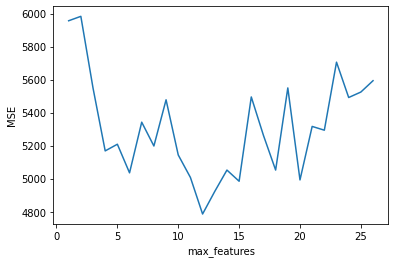

In [69]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('MSE')

In [70]:
results1 = {'values':feature_range, 'MSE': accuracy_scores}
res1 = pd.DataFrame(data=results1)
res1

,values,MSE
0,1,5956.946125
1,2,5983.679070
2,3,5549.485363
3,4,5168.597534
4,5,5209.009056
5,6,5035.727933
6,7,5342.590648
7,8,5198.237010
8,9,5478.135225
9,10,5144.069156


max_depth represents the depth of each tree in the forest. The deeper the tree, the more splits it has and it captures more information about the data. 

In [78]:
# list of values to try for max_depth: 
max_depth_range = range(10, 100,10)

# list to store the average RMSE for each value of max_depth
accuracy_scores = []

for depth in max_depth_range:
    clf =  RandomForestRegressor(max_depth=depth, n_estimators=110,max_features=12, random_state=1,n_jobs=-1)
    accuracy_scores.append(cross_validation(X_train, y_train, clf,k=10))
    
    

Text(0, 0.5, 'MSE')

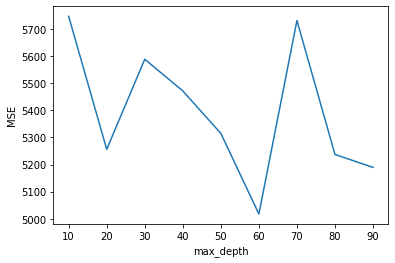

In [79]:
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('MSE')

In [80]:
results1 = {'values':max_depth_range, 'MSE': accuracy_scores}
res1 = pd.DataFrame(data=results1)
res1

,values,MSE
0,10,5746.422313
1,20,5256.330279
2,30,5588.179246
3,40,5471.509947
4,50,5314.807943
5,60,5017.731168
6,70,5731.051781
7,80,5237.141506
8,90,5189.513797


In [84]:
# model with the optimized parameters 
clf_optimizado =  RandomForestRegressor(max_depth=60, n_estimators=110, max_features=12, random_state=1,n_jobs=-1)
clf_optimizado.fit(X_train, y_train)
y_pr=clf_optimizado.predict(X_test)
mean_squared_error(y_test, y_pr)**0.5

5366.100933747831

Applying Random Forest Machine Learning with con kfold =10 reduces RMSE from 5431.5 to  5.366

## 3.4. XGBoost
XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework.

In [85]:
# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2, random_state=1)

In [86]:
#XGBoost
from xgboost import XGBRegressor
from sklearn import metrics
xgb = XGBRegressor()
xgb

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=False, verbosity=None)

In [87]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
metrics.mean_squared_error(y_pred, y_test.values)**0.5

5647.702361220791

n_estimators : represents the number of trees in the forest. Usually the higher the number of trees the better to learn the data.

learning_rate: A technique to slow down the learning in the gradient boosting model is to apply a weighting factor for the corrections by new trees when added to the model.

This weighting is called the shrinkage factor or the learning rate, depending on the literature or the tool.

Gamma: A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.
Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned. 

In [90]:
# XGB  

xg =  XGBRegressor( random_state=1,n_jobs=-1)
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)
metrics.mean_squared_error(y_pred, y_test.values)**0.5

5647.702361220791


Applying the XGBoost, the RMSE is 5.647

### *Parameter Tuning*

#### Parameters:

* Learning Rate: Step size shrinkage used in update to prevents overfitting.
* Max_Depth: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
* Col_Sample (By tree): Is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

In [91]:
# findind best value for learning_rate
learning_rate_range = np.arange(0, 1, 0.1)

# list to store the average RMSE
accuracy_scores = []

for lr in learning_rate_range:
    xg = XGBRegressor(objective="reg:linear",eta=lr, random_state=42)
    xg.fit(X_train, y_train)
    y_pred = xg.predict(X_test)
    accuracy_scores.append(mean_squared_error(y_test, y_pred)**0.5) 

[23:42:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:42:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:42:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:42:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:42:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:42:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:16

Text(0, 0.5, 'MSE')

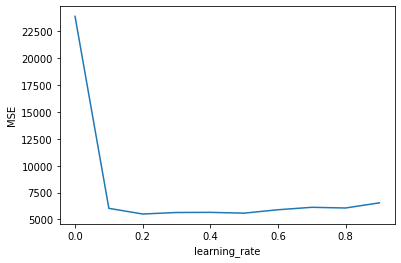

In [92]:
plt.plot(learning_rate_range, accuracy_scores)
plt.xlabel('learning_rate')
plt.ylabel('MSE')

In [93]:
results = {'values':learning_rate_range, 'accuracy': accuracy_scores}
res = pd.DataFrame(data=results)
res

,values,accuracy
0,0.0,23911.161532
1,0.1,6036.400803
2,0.2,5508.377545
3,0.3,5647.702361
4,0.4,5662.125348
5,0.5,5588.503195
6,0.6,5904.664252
7,0.7,6132.904170
8,0.8,6068.185965
9,0.9,6548.268369


In [94]:
res.min()

values         0.000000
accuracy    5508.377545
dtype: float64

In [95]:
# defining colsample_bytree
col_range = np.arange(0, 1, 0.1)

# list to store the average RMSE
accuracy_scores = []

for col in col_range:
    xgb_model = XGBRegressor(objective="reg:linear",colsample_bytree=col ,eta=0.2,random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    accuracy_scores.append(mean_squared_error(y_pred, y_test.values)**0.5) 

[23:42:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:42:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:42:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:42:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:42:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:42:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:16

Text(0, 0.5, 'MSE')

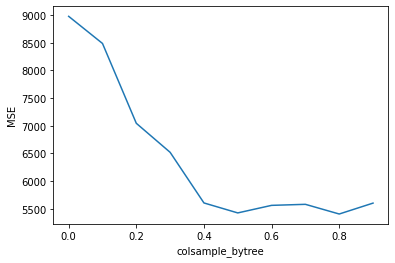

In [96]:
plt.plot(col_range, accuracy_scores)
plt.xlabel('colsample_bytree')
plt.ylabel('MSE')

In [97]:
results1 = {'values':col_range, 'MSE': accuracy_scores}
res1 = pd.DataFrame(data=results1)
res1

,values,MSE
0,0.0,8978.163832
1,0.1,8488.046755
2,0.2,7044.840891
3,0.3,6520.232218
4,0.4,5605.159379
5,0.5,5424.836818
6,0.6,5561.376981
7,0.7,5580.118868
8,0.8,5405.055093
9,0.9,5602.105426


In [99]:
res1.min()

values       0.000000
MSE       5405.055093
dtype: float64

In [101]:
# findind best value for max_depth
max_depth_range = range(0, 20, 2)

# list to store the average RMSE
accuracy_scores = []

for md in max_depth_range :
    xg = XGBRegressor(objective="reg:linear",eta=0.2,colsample_bytree=0.8 ,max_depth=md, random_state=42)
    xg.fit(X_train, y_train)
    y_pred = xg.predict(X_test)
    accuracy_scores.append(mean_squared_error(y_pred, y_test.values)**0.5) 

[23:44:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:16

Text(0, 0.5, 'MSE')

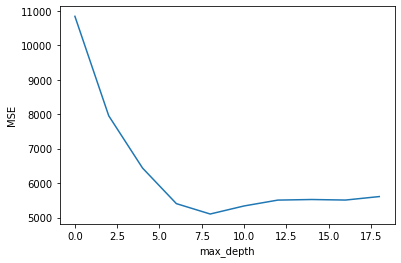

In [102]:
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('MSE')

In [103]:
results1 = {'values':max_depth_range, 'MSE': accuracy_scores}
res1 = pd.DataFrame(data=results1)
res1

,values,MSE
0,0,10846.437944
1,2,7957.110120
2,4,6438.600408
3,6,5405.055093
4,8,5103.602860
5,10,5337.214607
6,12,5507.729524
7,14,5524.754133
8,16,5509.171471
9,18,5610.280540


In [104]:
res1.min()

values       0.00000
MSE       5103.60286
dtype: float64

In [105]:
# XGB optimizado 

xg_op= XGBRegressor(objective="reg:linear",eta=0.2,colsample_bytree=0.8 ,max_depth=8, random_state=42)
xg_op.fit(X_train, y_train)
y_pred = xg_op.predict(X_test)
mean_squared_error(y_pred, y_test.values)**0.5

[23:44:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


5103.60285997384

The MSE for the XG Boosting is $5.103 with the Optimized parameters.

|  Parameters      | Value   |
| ---------------- |:-------:|
| Learning Rate    | 0.2     |
| Max_Depth        | 8       |   
| Col_Sample       | 0.8     |


## Results and Conclusions


|  Model           | MSE     |
| ---------------- |:-------:|
| Bagged Trees     | 5.475   |
| Random Forest    | 5366.10 |
| XG Boosting      | 5.103   |


According to the results, we can see that XGBoost is the model with the best performance (lower RMSE), with a RMSE of 5.103This model will be used in the API to predict the price of a car.




# API SET UP


### 1. Save model

In [54]:
import joblib

In [55]:
joblib.dump(clf_optimizado, 'model_deployment_proyecto/car_price_prediction.aaaa', compress=3)

['model_deployment_proyecto/car_price_prediction.aaaa']

In [56]:
joblib.dump(encoder, 'model_deployment_proyecto/encoder.aaaa', compress=3)

['model_deployment_proyecto/encoder.aaaa']

###  2. Model in batch

In [57]:
from model_deployment_proyecto.m09_model_deployment import predict_price

In [58]:
predict_price(Year=2015,Mileage=54593,State='MS',Make='Toyota',Model='CamrySE')

array([23355.37289266])

### 3.API

In [59]:
from flask import Flask
from flask_restx import Api, Resource, fields
import joblib
from model_deployment_proyecto.m09_model_deployment import predict_price

app = Flask(__name__)

api = Api(
    app, 
    version='1.0', 
    title='Car Prices Prediction API',
    description='Car Prices Prediction API')

ns = api.namespace('predict', 
     description='Price prediction')
   
parser = api.parser()

parser.add_argument(
    'Year', 
    type=int, 
    required=True, 
    help='Year to be analyzed', 
    location='args')

parser.add_argument(
    'Mileage', 
    type=int, 
    required=True, 
    help='Mileage to be analyzed', 
    location='args')

parser.add_argument(
    'State', 
    type=str, 
    required=True, 
    help='State to be analyzed', 
    location='args')

parser.add_argument(
    'Make', 
    type=str, 
    required=True, 
    help='Make to be analyzed', 
    location='args')


parser.add_argument(
    'Model', 
    type=str, 
    required=True, 
    help='Model to be analyzed', 
    location='args')

resource_fields = api.model('Resource', {
    'result': fields.String,
})

@ns.route('/')
class PhishingApi(Resource):

    @api.doc(parser=parser)
    @api.marshal_with(resource_fields)
    def get(self):
        args = parser.parse_args()
        
        return {
        "result": predict_price(args['Year'],args['Mileage'],args['State'],args['Make'],args['Model'])
        }, 200
    
    
if __name__ == '__main__':
    app.run(debug=True, use_reloader=False, host='0.0.0.0', port=5000)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)


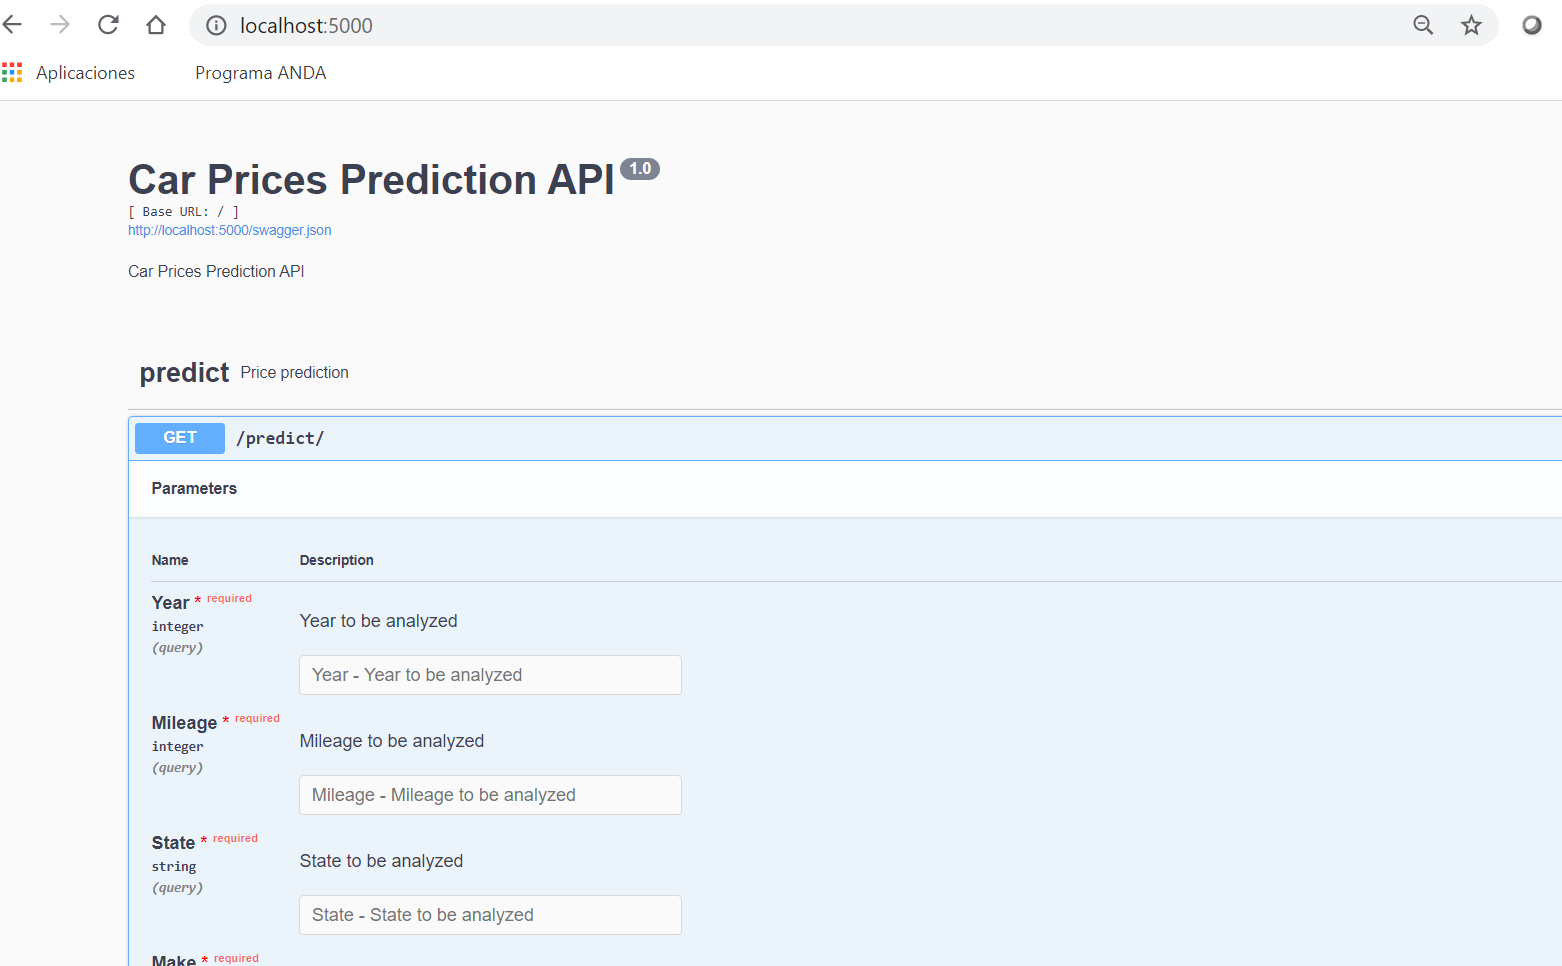

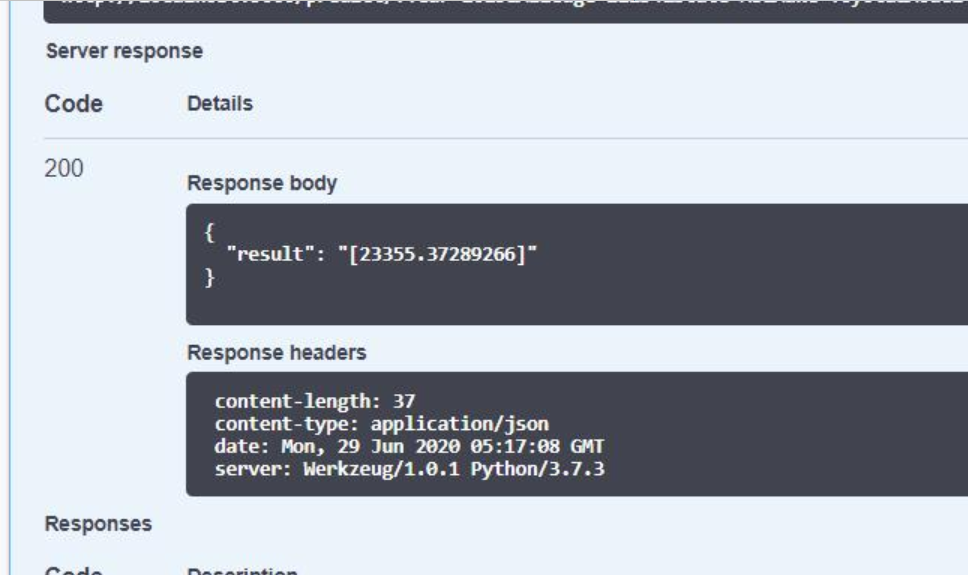

## 4. URL: 

http://ec2-35-171-89-118.compute-1.amazonaws.com:5000/